In [40]:
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import lasio


In [41]:
numpy.random.seed(7)
l=lasio.read(r'D:\geohack\LAS\5002320001.las') #reads the well log .las file
df = pd.DataFrame()

df['ild'] = l['ILD']

dataset = df.values
dataset = dataset.astype('float32')

In [42]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [57]:
# split into train and test sets
train_size = int(len(dataset) * 0.5)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1351 1352


In [58]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [59]:
# reshape into X=t and Y=t+1
look_back = 500
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [60]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [61]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, batch_size=1, verbose=2)

Epoch 1/10
4s - loss: 0.0011
Epoch 2/10
2s - loss: 4.3518e-04
Epoch 3/10
2s - loss: 3.5856e-04
Epoch 4/10
2s - loss: 2.7970e-04
Epoch 5/10
2s - loss: 2.2710e-04
Epoch 6/10
2s - loss: 1.8562e-04
Epoch 7/10
2s - loss: 1.7768e-04
Epoch 8/10
2s - loss: 2.0351e-04
Epoch 9/10
2s - loss: 1.3256e-04
Epoch 10/10
2s - loss: 1.5219e-04


In [62]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.75 RMSE
Test Score: 4.39 RMSE


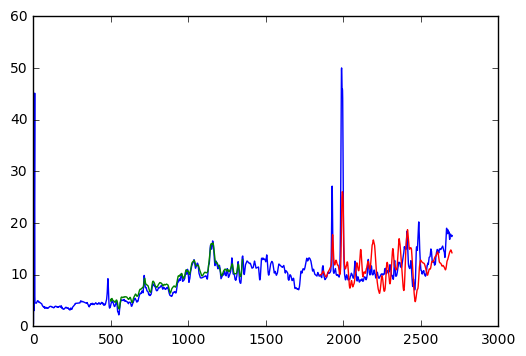

In [63]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()